# Using Neo4j's graph database with AG2 agents for Question & Answering

AG2 provides GraphRAG integration through agent capabilities. This is an example utilising the integration of Neo4j's property graph database with LlamaIndex's graph query engine.


````{=mdx}
:::info Requirements
To install the LlamaIndex, Neo4j, and document processing dependencies, install with the 'neo4j' extra:

```bash
pip install -U ag2[openai,neo4j]
```

> **Note:** If you have been using `autogen` or `ag2`, all you need to do is upgrade it using:  
> ```bash
> pip install -U autogen[openai,neo4j]
> ```
> or  
> ```bash
> pip install -U ag2[openai,neo4j]
> ```
> as `autogen`, and `ag2` are aliases for the same PyPI package.  

:::
````

## Set Configuration and OpenAI API Key

By default, in order to use LlamaIndex with Neo4j you need to have an OpenAI key in your environment variable `OPENAI_API_KEY`.

You can utilise an OAI_CONFIG_LIST file and extract the OpenAI API key and put it in the environment, as will be shown in the following cell.

Alternatively, you can load the environment variable yourself.

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](https://docs.ag2.ai/latest/docs/user-guide/basic-concepts/llm-configuration).
:::
````

In [ ]:
import os

import autogen

config_list = autogen.config_list_from_json(env_or_file="OAI_CONFIG_LIST")

# Put the OpenAI API key into the environment
os.environ["OPENAI_API_KEY"] = config_list[0]["api_key"]

In [ ]:
# This is needed to allow nested asyncio calls for Neo4j in Jupyter
import nest_asyncio

nest_asyncio.apply()

## Key Information: Using Neo4j with LLM Models 🚀

> **Important**  
> - **Default Models**:
>   - **Question Answering**: OpenAI's `GPT-4o` with `temperature=0.0`.
>   - **Embedding**: OpenAI's `text-embedding-3-small`.
> 
> - **Customization**:
>   You can change these defaults by setting the following parameters on the `Neo4jGraphQueryEngine`:
>   - `llm`: Specify a LLM instance with a llm you like.
>   - `embedding`: Specify a BaseEmbedding instance with a embedding model.
> - **Reference**
>   - https://docs.llamaindex.ai/en/stable/module_guides/models/llms/
>   - https://docs.llamaindex.ai/en/stable/examples/property_graph/graph_store/


## Create a Knowledge Graph with Your Own Data

**Note:** You need to have a Neo4j database running. If you are running one in a Docker container, please ensure your Docker network is setup to allow access to it. 

In this example, the Neo4j endpoint is set to host="bolt://172.17.0.3" and port=7687, please adjust accordingly. For how to spin up a Neo4j with Docker, you can refer to [this](https://docs.llamaindex.ai/en/stable/examples/property_graph/property_graph_neo4j/#:~:text=stores%2Dneo4j-,Docker%20Setup,%C2%B6,-To%20launch%20Neo4j)

We initialise the database with a Word document, creating the Property graph in Neo4j.

In [ ]:
# IMPORTS
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI

from autogen import ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.graph_rag.neo4j_graph_query_engine import Neo4jGraphQueryEngine

### A Simple Example

In this example, the graph schema is auto-generated. Entities and relationship are created as they fit into the data

LlamaIndex supports a lot of extensions including docx, text, pdf, csv, etc. Find more details in Neo4jGraphQueryEngine. You may need to install dependencies for each extension. In this example, we need `pip install docx2txt`

We start by creating a Neo4j property graph (knowledge graph) with a sample employee handbook of a fictional company called BUZZ

In [ ]:
# load documents
from autogen.agentchat.contrib.graph_rag.document import Document, DocumentType

input_path = "../test/agentchat/contrib/graph_rag/BUZZ_Employee_Handbook.docx"
input_documents = [Document(doctype=DocumentType.TEXT, path_or_url=input_path)]

In [ ]:
# pip install docx2txt
# Auto generate graph schema from unstructured data


# Create Neo4jGraphQueryEngine
query_engine = Neo4jGraphQueryEngine(
    username="neo4j",  # Change if you reset username
    password="password",  # Change if you reset password
    host="bolt://172.17.0.3",  # Change
    port=7687,  # if needed
    llm=OpenAI(model="gpt-4o", temperature=0.0),  # Default, no need to specify
    embedding=OpenAIEmbedding(model_name="text-embedding-3-small"),  # except you want to use a different model
    database="neo4j",  # Change if you want to store the graphh in your custom database
)

# Ingest data and create a new property graph
query_engine.init_db(input_doc=input_documents)

Instead of creating a new property graph, if you want to use an existing graph, you can connect to its database

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI

from autogen.agentchat.contrib.graph_rag.neo4j_graph_query_engine import Neo4jGraphQueryEngine

query_engine = Neo4jGraphQueryEngine(
    username="neo4j",  # Change if you reset username
    password="password",  # Change if you reset password
    host="bolt://172.17.0.3",  # Change
    port=7687,  # if needed
    llm=OpenAI(model="gpt-4o", temperature=0.0),  # Default, no need to specify
    embedding=OpenAIEmbedding(model_name="text-embedding-3-small"),  # except you want to use a different model
    database="neo4j",  # Change if you want to store the graphh in your custom database
)

# Connect to the existing graph
query_engine.connect_db()

An example property graph:

![neo4j_property_graph_1.png](https://media.githubusercontent.com/media/ag2ai/ag2/refs/heads/main/notebook/neo4j_property_graph_1.png)
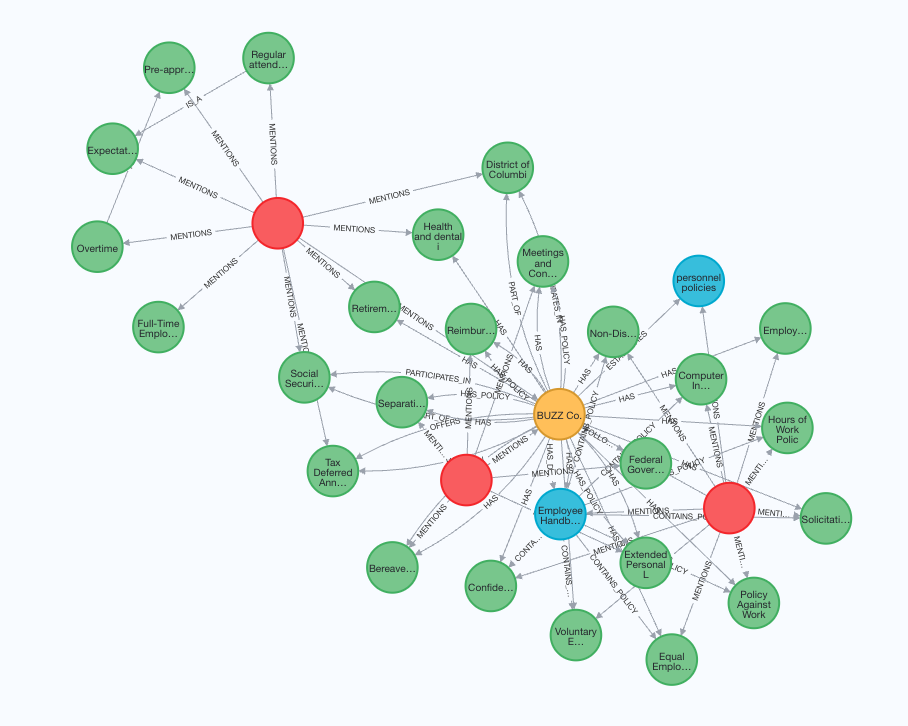

### Add capability to a ConversableAgent and query them
Notice that we intentionally moved the specific content of Equal Employment Opportunity Policy into a different document to add later

In [ ]:
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Create a ConversableAgent (no LLM configuration)
graph_rag_agent = ConversableAgent(
    name="buzz_agent",
    human_input_mode="NEVER",
)

# Associate the capability with the agent
graph_rag_capability = Neo4jGraphCapability(query_engine)
graph_rag_capability.add_to_agent(graph_rag_agent)

# Create a user proxy agent to converse with our RAG agent
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="ALWAYS",
)

user_proxy.initiate_chat(graph_rag_agent, message="Which company is the employer?")

### Revisit the example by defining custom entities, relations and schema

By providing custom entities, relations and schema, you could guide the engine to create a graph that better extracts the structure within the data.

We set `strict=True` to tell the engine to only extracting allowed relationships from the data for each entity



In [ ]:
from typing import Literal

# best practice to use upper-case
entities = Literal["EMPLOYEE", "EMPLOYER", "POLICY", "BENEFIT", "POSITION", "DEPARTMENT", "CONTRACT", "RESPONSIBILITY"]
relations = Literal[
    "FOLLOWS",
    "PROVIDES",
    "APPLIES_TO",
    "DEFINED_AS",
    "ASSIGNED_TO",
    "PART_OF",
    "MANAGES",
    "REQUIRES",
    "ENTITLED_TO",
    "REPORTS_TO",
]

# Define which entities can have which relationships. It can also be used a a guidance if strict is False.
schema = {
    "EMPLOYEE": ["FOLLOWS", "APPLIES_TO", "ASSIGNED_TO", "ENTITLED_TO", "REPORTS_TO"],
    "EMPLOYER": ["PROVIDES", "DEFINED_AS", "MANAGES", "REQUIRES"],
    "POLICY": ["APPLIES_TO", "DEFINED_AS", "REQUIRES"],
    "BENEFIT": ["PROVIDES", "ENTITLED_TO"],
    "POSITION": ["DEFINED_AS", "PART_OF", "ASSIGNED_TO"],
    "DEPARTMENT": ["PART_OF", "MANAGES", "REQUIRES"],
    "CONTRACT": ["PROVIDES", "REQUIRES", "APPLIES_TO"],
    "RESPONSIBILITY": ["ASSIGNED_TO", "REQUIRES", "DEFINED_AS"],
}

### Create the query engine and load the document

In [ ]:
# Create Neo4jGraphQueryEngine
query_engine = Neo4jGraphQueryEngine(
    username="neo4j",  # Change these as needed
    password="neo4jneo4j",
    host="bolt://192.168.0.115",
    port=7687,
    database="neo4j",
    llm=OpenAI(model="gpt-4o", temperature=0.0),
    embedding=OpenAIEmbedding(model_name="text-embedding-3-small"),
    entities=entities,  # possible entities
    relations=relations,  # possible relations
    schema=schema,
    strict=True,  # enforce the extracted relationships to be in the schema
)

# Ingest data and initialize the database
query_engine.init_db(input_doc=input_documents)

The Property graph screenshot is shown below:

![neo4j_property_graph_2.png](https://media.githubusercontent.com/media/ag2ai/ag2/refs/heads/main/notebook/neo4j_property_graph_2.png)
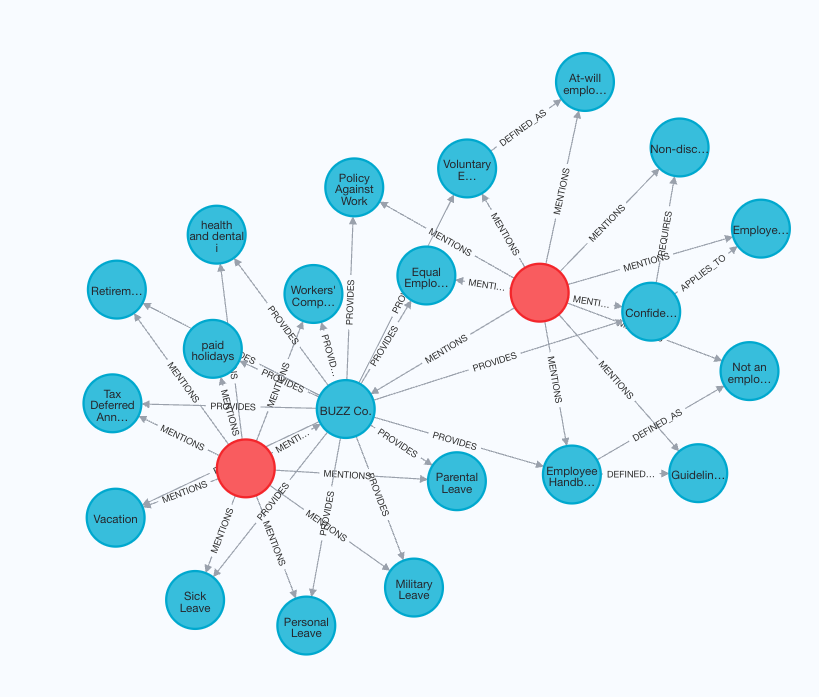

### Add capability to a ConversableAgent and query them again
You should find the answers are much more detailed and accurate since our schema fits well

In [ ]:
from autogen import ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Create a ConversableAgent (no LLM configuration)
graph_rag_agent = ConversableAgent(
    name="rag_agent",
    human_input_mode="NEVER",
)

# Associate the capability with the agent
graph_rag_capability = Neo4jGraphCapability(query_engine)
graph_rag_capability.add_to_agent(graph_rag_agent)

# Create a user proxy agent to converse with our RAG agent
user_proxy = UserProxyAgent(name="user_proxy", human_input_mode="ALWAYS", code_execution_config=False)

user_proxy.initiate_chat(graph_rag_agent, message="Which company is the employer?")

### Incrementally add new documents to the existing knoweledge graph.

In [ ]:
input_path = "../test/agentchat/contrib/graph_rag/BUZZ_Equal-Employment-Opportunity-Policy-Detailed.docx"
input_documents = [Document(doctype=DocumentType.TEXT, path_or_url=input_path)]

_ = query_engine.add_records(input_documents)

Checking the property graph, we'll find a different Equal Employment Opportunity Policy Node

![neo4j_property_graph_3.png](https://media.githubusercontent.com/media/ag2ai/ag2/refs/heads/main/notebook/neo4j_property_graph_3.png)
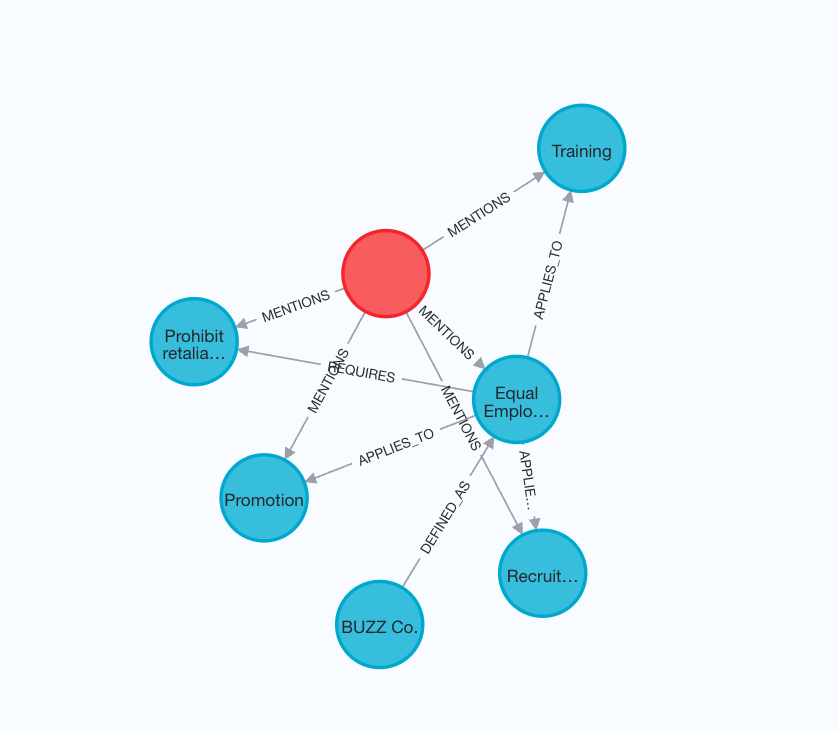

### Now let's create a new GraphRag agent and some questions related to both documents

In [ ]:
from autogen.agentchat.contrib.graph_rag.neo4j_graph_rag_capability import Neo4jGraphCapability

# Ask questions about both documents
user_proxy.initiate_chat(graph_rag_agent, message="What is Equal Employment Opportunity Policy at BUZZ?")